In [308]:

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import pandas as pd

import tensorflow as tf
import keras
from keras import ops
from keras import layers
from tensorflow.keras import metrics
import itertools

In [341]:
def initialize():
    # Path to the data directory
  data_dir = "/content/handwriting-recognition/test_v2/test/"
  train_csv = pd.read_csv('/content/handwriting-recognition/written_name_test_v2.csv')

  # TODO restore epoch count.
  epochs = 3
  early_stopping_patience = 10
  # Add early stopping
  early_stopping = keras.callbacks.EarlyStopping(
      monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
  )

  train_csv = train_csv[train_csv['IDENTITY'] != 'UNREADABLE']
  train_csv = train_csv[train_csv['IDENTITY'] != 'BLANK']
  train_csv = train_csv.sample(frac=0.05, random_state=42)
  print(train_csv.shape[0])

  images = list(train_csv['FILENAME'])
  labels = list(train_csv['IDENTITY'].astype(str))
  train_csv = train_csv.dropna(subset=['IDENTITY'])

  images = [os.path.join(data_dir, img) for img in images]

  characters = set(char for label in labels if isinstance(label, str) for char in label)
  characters = sorted(list(characters))

  print("Number of images found: ", len(images))
  print("Number of labels found: ", len(labels))
  print("Number of unique characters: ", len(characters))
  print("Characters present: ", characters)

  # Batch size for training and validation
  batch_size = 16

  # Desired image dimensions
  img_width = 200
  img_height = 40


  # Factor by which the image is going to be downsampled
  # by the convolutional blocks. We will be using two
  # convolution blocks and each block will have
  # a pooling layer which downsample the features by a factor of 2.
  # Hence total downsampling factor would be 4.
  downsample_factor = 4
  # Maximum length of any captcha in the dataset
  max_length = max([len(str(label)) for label in train_csv['IDENTITY']])
  print(max_length)
  labels = [label.ljust(max_length) for label in labels]

  # Mapping characters to integers
  char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

  # Mapping integers back to original characters
  num_to_char = layers.StringLookup(
      vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
  )

In [319]:
# Path to the data directory
data_dir = "/content/handwriting-recognition/test_v2/test/"
train_csv = pd.read_csv('/content/handwriting-recognition/written_name_test_v2.csv')

# TODO restore epoch count.
epochs = 3
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

train_csv = train_csv[train_csv['IDENTITY'] != 'UNREADABLE']
train_csv = train_csv[train_csv['IDENTITY'] != 'BLANK']
train_csv = train_csv.sample(frac=0.01, random_state=42)
print(train_csv.shape[0])

images = list(train_csv['FILENAME'])
labels = list(train_csv['IDENTITY'].astype(str))
train_csv = train_csv.dropna(subset=['IDENTITY'])

images = [os.path.join(data_dir, img) for img in images]

characters = set(char for label in labels if isinstance(label, str) for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 40


# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4
# Maximum length of any captcha in the dataset
max_length = max([len(str(label)) for label in train_csv['IDENTITY']])
print(max_length)
labels = [label.ljust(max_length) for label in labels]

# Mapping characters to integers
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

414
Number of images found:  414
Number of labels found:  414
Number of unique characters:  28
Characters present:  [' ', '-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
20


In [320]:
# Funkcje preprocessingu
def scale_image(scaller):
    img_width = int(200 * scaller)
    img_height = int(40 * scaller)



In [321]:


def split_data(images, labels, train_size=0.8, valid_size=0.1, test_size=0.1, shuffle=True, random_state=None):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    if shuffle:
        rng = np.random.default_rng(random_state)
        indices = rng.permutation(size)
    else:
        indices = np.arange(size)
    # 3. Get the sizes of training and validation samples
    train_samples = int(size * train_size)
    valid_samples = int(size * valid_size)
    test_samples = int(size * test_size)
    # 4. Split data into training, validation, and test sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:train_samples + valid_samples]], labels[indices[train_samples:train_samples + valid_samples]]
    x_test, y_test = images[indices[train_samples:train_samples + test_samples:]], labels[indices[train_samples:train_samples + test_samples:]]
    return x_train, x_valid, x_test, y_train, y_valid, y_test

# Splitting data into training and validation sets
x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(np.array(images), np.array(labels))

print(len(x_train))
print(len(x_valid))
print(len(x_test))


def encode_single_sample(img_path, label, scaller,normalization):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    # Zmieniono wielkość obrazu na nowe wymiary
    scale_image(scaller)
    img = tf.image.resize(img, [img_height, img_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = ops.transpose(img, axes=[1, 0, 2])

    # 6. Apply normalization
    if normalization == "zscore":
        img = tf.image.per_image_standardization(img)
    elif normalization == "minmax":
        img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))


    # 6. Map the characters in label to numbers
    print(label)
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    print(label)
    return {"image": img, "label": label}

331
41
41


In [325]:
def modify_dataset(scaling_factor,normalization):
  train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_dataset = (
      train_dataset.map(lambda x, y: encode_single_sample(x, y, scaling_factor, normalization), num_parallel_calls=tf.data.AUTOTUNE)
      .batch(batch_size)
      .prefetch(buffer_size=tf.data.AUTOTUNE)
  )

  validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
  validation_dataset = (
      validation_dataset.map(lambda x, y: encode_single_sample(x, y, scaling_factor,normalization), num_parallel_calls=tf.data.AUTOTUNE)
      .batch(batch_size)
      .prefetch(buffer_size=tf.data.AUTOTUNE)
  )

  test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
  test_dataset = (
      test_dataset.map(lambda x, y: encode_single_sample(x, y, scaling_factor,normalization), num_parallel_calls=tf.data.AUTOTUNE)
      .batch(batch_size)
      .prefetch(buffer_size=tf.data.AUTOTUNE)
  )
  return train_dataset,validation_dataset,test_dataset

In [326]:
def show_data(train_dataset):
  _, ax = plt.subplots(4, 4, figsize=(10, 5))
  for batch in train_dataset.take(1):
      print('a')
      images = batch["image"]
      labels = batch["label"]
      for i in range(16):
          img = (images[i] * 255).numpy().astype("uint8")
          label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
          ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
          ax[i // 4, i % 4].set_title(label)
          ax[i // 4, i % 4].axis("off")
  plt.show()

In [324]:
def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = ops.cast(ops.squeeze(label_length, axis=-1), dtype="int32")
    input_length = ops.cast(ops.squeeze(input_length, axis=-1), dtype="int32")
    sparse_labels = ops.cast(
        ctc_label_dense_to_sparse(y_true, label_length), dtype="int32"
    )

    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())

    return ops.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )


def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = ops.shape(labels)
    num_batches_tns = ops.stack([label_shape[0]])
    max_num_labels_tns = ops.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return ops.expand_dims(ops.arange(ops.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = ops.cast(tf.fill([1, label_shape[1]], 0), dtype="bool")
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = ops.reshape(
        ops.tile(ops.arange(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = ops.transpose(
        ops.reshape(
            ops.tile(ops.arange(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = ops.transpose(
        ops.reshape(ops.concatenate([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        ops.cast(indices, dtype="int64"),
        vals_sparse,
        ops.cast(label_shape, dtype="int64")
    )

@keras.saving.register_keras_serializable(package="customs", name="CTCLayer")
class CTCLayer(layers.Layer):
    # def __init__(self, name=None):
    #     super().__init__(name=name)
    #     self.loss_fn = ctc_batch_cost
    def __init__(self, trainable=True, dtype='float32', name=None, **kwargs):
        super().__init__(trainable=trainable, dtype=dtype, name=name, **kwargs)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = ops.cast(ops.shape(y_true)[0], dtype="int64")
        input_length = ops.cast(ops.shape(y_pred)[1], dtype="int64")
        label_length = ops.cast(ops.shape(y_true)[1], dtype="int64")

        input_length = input_length * ops.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * ops.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

def build_model(num_conv_layers=2, filter_size=3, activation='tanh'):
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    x = input_img
    for i in range(num_conv_layers):
        x = layers.Conv2D(
            64,
            (filter_size, filter_size),
            activation=activation,
            kernel_initializer="he_normal",
            padding="same",
            name=f"Conv{i+1}",
        )(x)
        x = layers.MaxPooling2D((2, 2), name=f"pool{i+1}")(x)

    downscale_factor = 2 ** num_conv_layers
    new_shape = ((img_width // downscale_factor), (img_height // downscale_factor) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)



    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

# Get the model
model = build_model()
model.summary()


Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 200, 40, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 200, 40, 64)    │            640 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 100, 20, 64)    │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 100, 20, 64)    │         36,928 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 50, 10, 64)     │              0 │ Conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 50, 640)        │              0 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 50, 64)         │         41,024 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 50, 64)         │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 50, 30)         │          1,950 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 50, 30)         │              0 │ label[0][0],           │
│                           │                        │                │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 80,542 (314.62 KB)

 Trainable params: 80,542 (314.62 KB)

 Non-trainable params: 0 (0.00 B)

In [316]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 443ms/step - loss: 522.6913 - val_loss: 438.8657
Epoch 2/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 527ms/step - loss: 506.6138 - val_loss: 433.8041
Epoch 3/3
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - loss: 501.8359

KeyboardInterrupt: 

In [296]:
model.save("trained_model.keras")

In [297]:

preds = model.predict(test_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


In [298]:
def ctc_decode2(y_pred):
    input_length = np.ones(preds.shape[0]) * preds.shape[1]
    input_shape = ops.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())
    input_length = ops.cast(input_length, dtype="int32")

    (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
        inputs=y_pred, sequence_length=input_length
    )

    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))

    dec = (decoded_dense, log_prob)

    return dec

def decode_to_utf8(y_pred):
    y_pred = np.where(y_pred == -1, 1, y_pred)
    charst = num_to_char(y_pred)
    decoded_text_numpy = np.array(charst)
    decoded_text_utf8 = np.char.decode(decoded_text_numpy.astype('bytes'), 'utf-8')

    res_words = [''.join(filter(lambda x: x != ' ', row)) for row in decoded_text_utf8]

    return res_words

In [299]:

dec = ctc_decode2(preds)[0][0][
        :, :max_length
    ]
print(dec.shape)
# res = decode_to_utf8(dec)
# print(res)

for batch in test_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]

print(len(batch_images))
print(len(batch_labels))

(41, 20)
9
9


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 200, 40, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 200, 40, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 100, 20, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 100, 20, 64)         │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 50, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 50, 640)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 50, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 50, 30)              │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,542 (314.62 KB)

 Trainable params: 80,542 (314.62 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


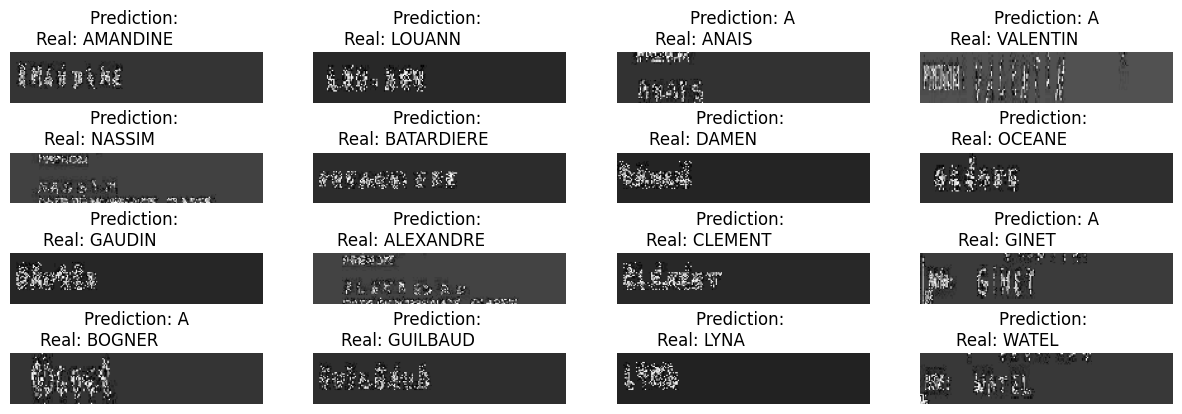

In [300]:
prediction_model = keras.models.Model(
    model.input[0], model.get_layer(name="dense2").output
)
prediction_model.summary()
#  Let's check results on some validation samples
for batch in test_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    # pred_texts = decode_batch_predictions(preds)

    dec = ctc_decode2(preds)[0][0][
        :, :max_length
    ]
    pred_texts = decode_to_utf8(dec)
    # pred_texts = pred_texts.astype(str)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}\nReal: {orig_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [301]:
def levenshtein(s1, s2):
    dp = [[0] * (len(s2) + 1) for _ in range(len(s1) + 1)]

    for i in range(len(s1) + 1):
        dp[i][0] = i
    for j in range(len(s2) + 1):
        dp[0][j] = j

    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            if s1[i - 1] == s2[j - 1]:
                cost = 0
            else:
                cost = 1
            dp[i][j] = min(dp[i - 1][j] + 1,
                           dp[i][j - 1] + 1,
                           dp[i - 1][j - 1] + cost)
    return dp[len(s1)][len(s2)]

In [302]:
total_distance = 0
num_samples = 0
for batch in validation_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    dec = ctc_decode2(preds)[0][0][
        :, :max_length
    ]
    pred_texts = decode_to_utf8(dec)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    for i in range(len(pred_texts)):
        total_distance += levenshtein(pred_texts[i], orig_texts[i])
        num_samples += 1


# Calculate and print the average Levenshtein distance
average_distance = total_distance / num_samples
print(f"Average Levenshtein Distance: {average_distance}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Average Levenshtein Distance: 19.853658536585368


In [338]:
def results(model,test_dataset,validation_dataset):
  preds = model.predict(test_dataset)
  prediction_model = keras.models.Model(
      model.input[0], model.get_layer(name="dense2").output
  )
  prediction_model.summary()
  #  Let's check results on some validation samples
  for batch in test_dataset.take(1):
      batch_images = batch["image"]
      batch_labels = batch["label"]

      preds = prediction_model.predict(batch_images)
      # pred_texts = decode_batch_predictions(preds)

      dec = ctc_decode2(preds)[0][0][
          :, :max_length
      ]
      pred_texts = decode_to_utf8(dec)
      # pred_texts = pred_texts.astype(str)

      orig_texts = []
      for label in batch_labels:
          label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
          orig_texts.append(label)

      _, ax = plt.subplots(4, 4, figsize=(15, 5))
      for i in range(len(pred_texts)):
          img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
          img = img.T
          title = f"Prediction: {pred_texts[i]}\nReal: {orig_texts[i]}"
          ax[i // 4, i % 4].imshow(img, cmap="gray")
          ax[i // 4, i % 4].set_title(title)
          ax[i // 4, i % 4].axis("off")
  plt.show()

  total_distance = 0
  num_samples = 0
  for batch in validation_dataset:
      batch_images = batch["image"]
      batch_labels = batch["label"]

      preds = prediction_model.predict(batch_images)
      dec = ctc_decode2(preds)[0][0][
          :, :max_length
      ]
      pred_texts = decode_to_utf8(dec)

      orig_texts = []
      for label in batch_labels:
          label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
          orig_texts.append(label)

      for i in range(len(pred_texts)):
          total_distance += levenshtein(pred_texts[i], orig_texts[i])
          num_samples += 1


  # Calculate and print the average Levenshtein distance
  average_distance = total_distance / num_samples
  print(f"Average Levenshtein Distance: {average_distance}")

In [339]:
# Eksperyment 1: Preprocessing Image Techniques
def experiment_preprocessing():
    scaling_factors = [0.5, 1.0, 1.5]
    normalizations = ["zscore", "minmax"]
    preprocessing_combinations = list(itertools.product(scaling_factors, normalizations))

    for combination in preprocessing_combinations:
        scaling_factor, normalization = combination
        print(f"Preprocessing combination: Scaling factor: {scaling_factor}, Normalization: {normalization}")
        initialize()
        # Splitting data into training and validation sets
        x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(np.array(images), np.array(labels))
        train_dataset,validation_dataset,test_dataset= modify_dataset(scaling_factor,normalization)
        show_data(train_dataset)
        # Utwórz model dla danej kombinacji preprocessingu
        model = build_model()  # Tutaj możesz dodać odpowiednie argumenty, aby dostosować model do kombinacji preprocessingu

        # Trenuj model na danych treningowych
        history = model.fit(
            train_dataset,
            validation_data=validation_dataset,
            epochs=epochs,
            callbacks=[early_stopping],
            verbose=1  # Możesz ustawić verbose na 0, aby ukryć wyjście treningowe
        )
        results(model,test_dataset,validation_dataset)


# Eksperyment 2: Hyperparameter Optimization
def experiment_hyperparameters(scaling_factor,normalization):
    filter_sizes = [5, 10, 15]
    activations = ["tanh", "relu", "sigmoid", "softmax"]
    hyperparameter_combinations = list(itertools.product(filter_sizes, activations))

    for combination in hyperparameter_combinations:
        # Splitting data into training and validation sets
        x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(np.array(images), np.array(labels))
        filter_size, activation = combination
        print(f"Hyperparameter combination: Filter Size: {filter_size}, Activation: {activation}")
        train_dataset,validation_dataset,test_dataset=modify_dataset(scaling_factor,normalization)
        show_data(train_dataset)
        # Utwórz model dla danej kombinacji hiperparametrów
        model = build_model(filter_size=filter_size, activation=activation)  # Tutaj możesz dodać odpowiednie argumenty, aby dostosować model do kombinacji hiperparametrów

        # Trenuj model na danych treningowych
        history = model.fit(
            train_dataset,
            validation_data=validation_dataset,
            epochs=epochs,
            callbacks=[early_stopping],
            verbose=1  # Możesz ustawić verbose na 0, aby ukryć wyjście treningowe
        )
        preds = model.predict(test_dataset)
        prediction_model = keras.models.Model(model.input[0], model.get_layer(name="dense2").output)
        prediction_model.summary()
        # Ocena modelu na danych walidacyjnych
        total_distance = 0
        num_samples = 0
        for batch in validation_dataset:
            batch_images = batch["image"]
            batch_labels = batch["label"]

            preds = prediction_model.predict(batch_images)
            dec = ctc_decode2(preds)[0][0][:, :max_length]
            pred_texts = decode_to_utf8(dec)

            orig_texts = []
            for label in batch_labels:
                label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                orig_texts.append(label)

            for i in range(len(pred_texts)):
                total_distance += levenshtein(pred_texts[i], orig_texts[i])
                num_samples += 1

        # Obliczenie i wydrukowanie średniego dystansu Levenshteina
        average_distance = total_distance / num_samples
        print(f"Average Levenshtein Distance: {average_distance}")


Preprocessing combination: Scaling factor: 0.5, Normalization: zscore
2068
Number of images found:  2068
Number of labels found:  2068
Number of unique characters:  31
Characters present:  [' ', "'", '-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'n']
20
Tensor("args_1:0", shape=(), dtype=string)
Tensor("string_lookup_102_1/Identity:0", shape=(None,), dtype=int64)
Tensor("args_1:0", shape=(), dtype=string)
Tensor("string_lookup_102_1/Identity:0", shape=(None,), dtype=int64)
Tensor("args_1:0", shape=(), dtype=string)
Tensor("string_lookup_102_1/Identity:0", shape=(None,), dtype=int64)
a


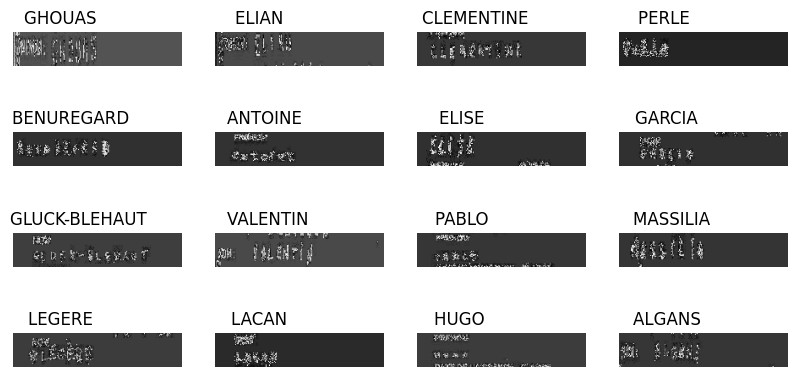

Epoch 1/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 358ms/step - loss: 1105.2739 - val_loss: 520.0529
Epoch 2/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 412ms/step - loss: 570.9468 - val_loss: 498.6848
Epoch 3/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - loss: 543.9538 - val_loss: 484.4502
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 200, 40, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 200, 40, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 100, 20, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 100, 20, 64)         │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 50, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 50, 640)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 50, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 50, 30)              │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,542 (314.62 KB)

 Trainable params: 80,542 (314.62 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


FailedPreconditionError: {{function_node __wrapped__CTCGreedyDecoder_device_/job:localhost/replica:0/task:0/device:CPU:0}} len(sequence_length) != batch_size.  len(sequence_length):  9 batch_size: 16 [Op:CTCGreedyDecoder] name: 

In [342]:
experiment_preprocessing()

In [ ]:
experiment_hyperparameters()